***
## Linear Model
***

In [2]:
# requirement package
import pandas as pd
import sympy as sym
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
# Choose the style
plt.style.use('seaborn-v0_8-whitegrid')

# Always print floating point numbers using fixed point notation
np.set_printoptions(suppress = True)

In [3]:
# Require Dataset
from faraway.datasets import savings
from faraway.datasets import odor
from faraway.datasets import galapagos
from faraway.datasets import globwarm
from faraway.datasets import sexab
from faraway.datasets import fruitfly
from faraway.datasets import statedata
from faraway.datasets import seatpos

***
## Estimate Coefficient
***

In [3]:
X = np.array([1.47,1.5,1.52,1.55,1.57,
              1.6,1.63,1.65,1.68,1.7,
              1.73,1.75,1.78,1.80,1.83])
# model matrix
Xm = sm.add_constant(X)
y = np.array([52.21,53.12,54.48,55.84,57.2,
              58.57,59.93,61.29,63.11,64.47,
              66.28,68.1,69.92,72.19,74.46]).reshape(-1,1)
display(Xm,
        Xm.shape,
        y,
        y.shape)

array([[1.  , 1.47],
       [1.  , 1.5 ],
       [1.  , 1.52],
       [1.  , 1.55],
       [1.  , 1.57],
       [1.  , 1.6 ],
       [1.  , 1.63],
       [1.  , 1.65],
       [1.  , 1.68],
       [1.  , 1.7 ],
       [1.  , 1.73],
       [1.  , 1.75],
       [1.  , 1.78],
       [1.  , 1.8 ],
       [1.  , 1.83]])

(15, 2)

array([[52.21],
       [53.12],
       [54.48],
       [55.84],
       [57.2 ],
       [58.57],
       [59.93],
       [61.29],
       [63.11],
       [64.47],
       [66.28],
       [68.1 ],
       [69.92],
       [72.19],
       [74.46]])

(15, 1)

In [4]:
def Grad_D(X,y,beta_int = np.ones((2,1)),tols = 1e-9,alpha = 1e-3):
	count = 0
	# Do the Gradient descent
	while True:
		beta_curr = beta_int - alpha * 2 * (X.T @ (X @ beta_int - y))
		count += 1
		# L2 norm
		rmse = np.linalg.vector_norm(beta_curr - beta_int,ord = 2)
		if rmse < tols:
			break
		rpt_str = f'iter {count}'
		rpt_str += ': {:.4f} {:.4f}'.format(*beta_curr.ravel())
		beta_int = beta_curr
	return beta_int.ravel()

In [5]:
def MLE_Est(X,y,beta_int = np.ones(2)):
	# Define log likelihood
	neg_LL = lambda beta: -1 * np.sum(scs.norm.logpdf(y,X @ np.array([[beta[0]],[beta[1]]]),1))
	# Find the critical point
	beta_mle = sp.optimize.minimize(neg_LL,beta_int,method = 'L-BFGS-B')
	return beta_mle.x

In [6]:
# OLS vs GD
beta_inv = np.linalg.inv(Xm.T @ Xm) @ (Xm.T @ y)
beta_solve = np.linalg.solve(Xm.T @ Xm,Xm.T @ y)
beta_GD = Grad_D(Xm,y)
beta_mle = MLE_Est(Xm,y)
display(beta_inv.ravel(),
        beta_solve.ravel(),
        beta_GD,
        beta_mle)

array([-39.06195592,  61.27218654])

array([-39.06195592,  61.27218654])

array([-39.06194717,  61.27218126])

array([-39.06195553,  61.27218625])

In [7]:
# 計算速度比較
%timeit np.linalg.inv(Xm.T @ Xm) @ (Xm.T @ y)
%timeit np.linalg.solve(Xm.T @ Xm,Xm.T @ y)
# %timeit Grad_D(Xm,y,np.ones((2,1)))
# %timeit MLE_Est(Xm,y)

6.27 μs ± 42 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
6.05 μs ± 437 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
# fake dataset
df_fake = pd.DataFrame([X,y.ravel()],index = ['X','y']).T
df_fake.head()

,X,y
0,1.47,52.21
1,1.50,53.12
2,1.52,54.48
3,1.55,55.84
4,1.57,57.20


In [9]:
# By statsmodel package formula api
model_f = smf.ols('y ~ X',data = df_fake).fit()
model_f.summary().tables[1]

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-39.0620,2.938,-13.295,0.000,-45.409,-32.715
X,61.2722,1.776,34.502,0.000,57.436,65.109


In [10]:
# By statsmodel another api
sm.OLS(y,Xm).fit().summary().tables[1]

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


,coef,std err,t,P>|t|,[0.025,0.975]
const,-39.0620,2.938,-13.295,0.000,-45.409,-32.715
x1,61.2722,1.776,34.502,0.000,57.436,65.109


In [11]:
# ML tools
lm = LinearRegression()
lm.fit(X.reshape(-1,1),y)
display(np.concatenate([lm.intercept_,lm.coef_[0]]))

array([-39.06195592,  61.27218654])

***
## Constraint Least Square
***

In [12]:
df_sav = savings.load()
df_sav.head()

,sr,pop15,pop75,dpi,ddpi
Australia,11.43,29.35,2.87,2329.68,2.87
Austria,12.07,23.32,4.41,1507.99,3.93
Belgium,13.17,23.80,4.43,2108.47,3.82
Bolivia,5.75,41.89,1.67,189.13,0.22
Brazil,12.88,42.19,0.83,728.47,4.56


In [13]:
Xc = sm.add_constant(df_sav.values[:,1:])
yc = df_sav.values[:,1].reshape(-1,1)
Am = np.array([[0,1,1,0,0]])
const = np.array([[0]])
iXtX = np.linalg.inv(Xc.T @ Xc)
beta_ols = iXtX @ (Xc.T @ yc)
beta_cls = beta_ols - iXtX @ Am.T @ np.linalg.inv(Am @ iXtX @ Am.T) @ (Am @ beta_ols - const)
beta_cls

array([[ 5.22292317],
       [ 0.90182819],
       [-0.90182819],
       [ 0.00024118],
       [ 0.00608082]])

In [14]:
# Create Variable
beta = cp.Variable((5,1))
# Set objective function
obj = cp.Minimize(cp.sum_squares(yc - Xc @ beta))
# Set Constraint
cstr = [Am @ beta == const]
# Solver
problem = cp.Problem(obj,cstr)
problem.solve()
# 結果
display(beta.value)

array([[ 5.22292317],
       [ 0.90182819],
       [-0.90182819],
       [ 0.00024118],
       [ 0.00608082]])

***
## Projection Matrix
***

In [15]:
P = Xm @ np.linalg.inv(Xm.T @ Xm) @ Xm.T
display(P @ Xm - Xm,
        P @ y - model_f.fittedvalues.values.reshape(-1,1))

array([[-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.]])

array([[-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.],
       [-0.]])

***
## ANOVA decomposition
***

In [16]:
vec1 = np.ones(y.shape)
I = np.eye(vec1.shape[0])
J = (vec1 @ vec1.T) / vec1.shape[0]
anova_decomp = {'SST':y.T @ (I - J) @ y,
                'SSR':y.T @ (P - J) @ y,
                'SSE':y.T @ (I - P) @ y}
anova_default = sm.stats.anova_lm(model_f)
display(anova_decomp,
        anova_default)

{'SST': array([[693.37264]]),
 'SSR': array([[685.8820816]]),
 'SSE': array([[7.4905584]])}

,df,sum_sq,mean_sq,F,PR(>F)
X,1.0,685.882082,685.882082,1190.360796,3.603515e-14
Residual,13.0,7.490558,0.576197,NaN,NaN


***
## Hypothesis Testing
***

In [17]:
# Complete model
full_model = smf.ols('sr ~ pop15 + pop75 + dpi + ddpi',data = df_sav).fit()
display(full_model.summary(slim = True),
        sm.stats.anova_lm(full_model))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sr   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.280
No. Observations:                  50   F-statistic:                     5.756
Covariance Type:            nonrobust   Prob (F-statistic):           0.000790
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.5661      7.355      3.884      0.000      13.753      43.379
pop15         -0.4612      0.145     -3.189      0.003      -0.753      -0.170
pop75         -1.6915      1.084     -1.561      0.126      -3.874       0.491
dpi           -0.0003      0.001     -0.362      0.719      -0.002       0.002
ddpi           0.4097      0.196      2.088      0.042       0.015       0.805
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
pop15,1.0,204.117565,204.117565,14.115732,0.000492
pop75,1.0,53.342710,53.342710,3.688910,0.061125
dpi,1.0,12.400946,12.400946,0.857586,0.359355
ddpi,1.0,63.054031,63.054031,4.360496,0.042471
Residual,45.0,650.712998,14.460289,NaN,NaN


In [18]:
# Test all predictors
reduce_model = smf.ols('sr ~ 1',data = df_sav).fit()
sm.stats.anova_lm(reduce_model,full_model).dropna()

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
1,45.0,650.712998,4.0,332.915252,5.755681,0.00079


In [19]:
# Test one predictor
X_names = ['pop15','pop75','dpi','ddpi']
dL = pd.DataFrame([])
for k in X_names:
    tmp = X_names.copy()
    tmp.remove(k)
    model_1 = smf.ols('sr ~ ' + ' + '.join(tmp),data = df_sav).fit()
    res = sm.stats.anova_lm(model_1,full_model).dropna()
    res.index = [f'Test coef of {k} = 0']
    dL = pd.concat([dL,res[['F','Pr(>F)']]])
dL

,F,Pr(>F)
Test coef of pop15 = 0,10.166595,0.002603
Test coef of pop75 = 0,2.436720,0.125530
Test coef of dpi = 0,0.130920,0.719173
Test coef of ddpi = 0,4.360496,0.042471


In [20]:
# Test pair of predictor
model_2 = smf.ols('sr ~ pop15 + ddpi',data = df_sav).fit()
display('Test coef of pop75 = dpi = 0',
      	sm.stats.anova_lm(model_2,full_model).dropna()[['F','Pr(>F)']])

'Test coef of pop75 = dpi = 0'

,F,Pr(>F)
1,1.723301,0.190045


In [21]:
# Test subset bi = bj
model_3 = smf.ols('sr ~ np.add(pop15,pop75) + dpi + ddpi',data = df_sav).fit()
display('Test coef of pop15 = pop75',
        sm.stats.anova_lm(model_3,full_model).dropna()[['F','Pr(>F)']])

'Test coef of pop15 = pop75'

,F,Pr(>F)
1,1.584652,0.214583


***
## Linear Hypothesis Test
***

In [22]:
b = sym.symbols('b0 b1 b2 b3 b4')
coefL = [[0,2,-1,0,0],
         [0,0,1,-2,3],
         [0,1,0,0,-1]]
betaL = sym.Matrix([b]).T
Rm = sym.Matrix(coefL)
display(Rm,
        betaL,
        Rm @ betaL)

Matrix([
[0, 2, -1,  0,  0],
[0, 0,  1, -2,  3],
[0, 1,  0,  0, -1]])

Matrix([
[b0],
[b1],
[b2],
[b3],
[b4]])

Matrix([
[       2*b1 - b2],
[b2 - 2*b3 + 3*b4],
[         b1 - b4]])

In [23]:
r = np.array(coefL)
LH_test = full_model.f_test(r)
display(r,
        LH_test.fvalue,
        LH_test.pvalue.item())

array([[ 0,  2, -1,  0,  0],
       [ 0,  0,  1, -2,  3],
       [ 0,  1,  0,  0, -1]])

6.578550878189696

0.000879078484072512

***
## Confidence Interval
***

In [24]:
# Confidence Interval for coefficients
full_model.conf_int().rename(columns = {0:'2.5%',1:'97.5%'})

,2.5%,97.5%
Intercept,13.753331,43.378842
pop15,-0.752518,-0.169869
pop75,-3.873978,0.490983
dpi,-0.002212,0.001538
ddpi,0.014534,0.804856


In [25]:
# By theorem
pred_input1 = {'pop15':4,
               'pop75':3,
               'dpi':1000,
               'ddpi':3}
# yhat
pred_y = full_model.predict(pred_input1).values
# Get model matrix
Xm = full_model.model.wexog
x0 = np.array([1,4,3,1000,3]).reshape(-1,1)
shat = np.sqrt(full_model.scale)
df_resid = int(full_model.df_resid)
sq_term = x0.T @ np.linalg.inv(Xm.T @ Xm) @ x0
mr1 = np.sqrt(sq_term) * shat * scs.t.ppf(0.975,df_resid)
mr2 = np.sqrt(1 + sq_term) * shat * scs.t.ppf(0.975,df_resid)
display(pred_y,
        np.sqrt(sq_term) * shat,
        pred_y - mr1,
		pred_y + mr1,
        pred_y - mr2,
		pred_y + mr2)

array([22.53900384])

array([[4.02867829]])

array([[14.42482924]])

array([[30.65317844]])

array([[11.38106418]])

array([[33.69694349]])

In [26]:
# prediction interval
full_model.get_prediction(pred_input1).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,22.539004,4.028678,14.424829,30.653178,11.381064,33.696943


In [27]:
pred_input2 = pd.DataFrame(df_sav.iloc[:,1:].mean()).T
full_model.get_prediction(pred_input2).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,9.671,0.537779,8.587858,10.754142,1.935822,17.406178


***
## Confidence Band
***

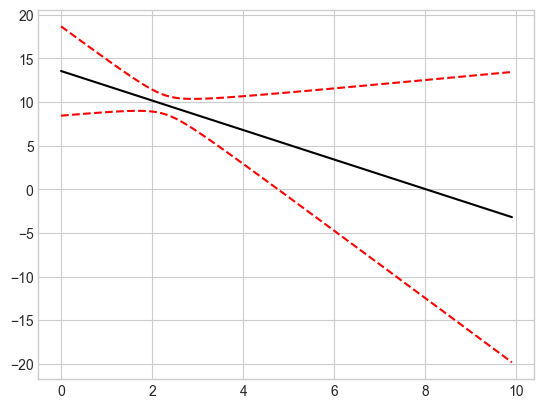

In [28]:
grids = np.arange(0,10,0.1)
dL = []
for k in grids:
    x0 = {j:df_sav[j].mean().item() if j in ['pop15','dpi','ddpi'] 
          else k.item() for j in df_sav.columns[1:]}
    y0 = full_model.get_prediction(x0).summary_frame()
    dL.append(y0)
dL = pd.concat(dL)
plt.plot(grids,dL['mean_ci_lower'],color = 'red',linestyle = 'dashed')
plt.plot(grids,dL['mean_ci_upper'],color = 'red',linestyle = 'dashed')
plt.plot(grids,dL['mean'],color = 'black')

***
## Orthogonality
***


In [29]:
df_odor = odor.load()
df_odor.head()

,odor,temp,gas,pack
0,66,-1,-1,0
1,39,1,-1,0
2,43,-1,1,0
3,49,1,1,0
4,58,-1,0,-1


In [30]:
Xd = df_odor.values[:,1:]
Xm = sm.add_constant(Xd)
Xm[:,1] = Xm[:,1] * 40 + 80
np.around(Xm.T @ Xm,8)

array([[    15.,   1200.,      0.,      0.],
       [  1200., 108800.,      0.,      0.],
       [     0.,      0.,      8.,      0.],
       [     0.,      0.,      0.,      8.]])

In [31]:
res1 = smf.ols('odor ~ temp + gas + pack',data = df_odor).fit()
res2 = smf.ols('odor ~ gas + pack',data = df_odor).fit()
pd.concat([res1.params,res1.tvalues,res1.pvalues],axis = 1).rename(columns = {0:'coef',1:'t',2:'P>|t|'})

,coef,t,P>|t|
Intercept,15.200,1.634735,0.130371
temp,-12.125,-0.952324,0.361390
gas,-17.000,-1.335218,0.208779
pack,-21.375,-1.678840,0.121332


In [32]:
pd.concat([res2.params,res2.tvalues,res2.pvalues],axis = 1).rename(columns = {0:'coef',1:'t',2:'P>|t|'})

,coef,t,P>|t|
Intercept,15.200,1.641112,0.126704
gas,-17.000,-1.340426,0.204933
pack,-21.375,-1.685389,0.117719


***
## Identifiability
***

In [33]:
df_sav['eq'] = df_sav.apply(lambda x:100 - x.pop15 - x.pop75,axis = 1)
eq_model = smf.ols('sr ~ eq + pop15 + pop75 + dpi + ddpi',data = df_sav).fit()
eq_model.summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sr   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.280
No. Observations:                  50   F-statistic:                     5.756
Covariance Type:            nonrobust   Prob (F-statistic):           0.000790
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0130      0.010     -1.274      0.209      -0.033       0.008
eq             0.2858      0.074      3.882      0.000       0.138       0.434
pop15         -0.1754      0.073     -2.391      0.021      -0.323      -0.028
pop75         -1.4057      1.025     -1.372      0.177      -3.470       0.659
dpi           -0.0003      0.001     -0.362      0.719      -0.002       0.002
ddpi           0.4097      0.196      2.088      0.042       0.015       0.805
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.95e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

***
## GLS
***

In [34]:
n = 100
X = sm.add_constant(np.random.rand(n,2))
# Let error be AR(1)
err = np.random.randn(n)
for t in range(1,n):
    err[t] += 0.5 * err[t]
beta = np.array([1,0.5,-0.3])
y = X @ beta + err
model_cret = sm.OLS(y,X).fit()
model_cret.summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.008
No. Observations:                 100   F-statistic:                     1.386
Covariance Type:            nonrobust   Prob (F-statistic):              0.255
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9474      0.352      2.690      0.008       0.248       1.646
x1             0.7330      0.446      1.645      0.103      -0.151       1.617
x2            -0.1157      0.479     -0.241      0.810      -1.067       0.835
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
resid = model_cret.resid
covM = np.diag(resid**2)
model_GLS = sm.GLS(y,X,sigma = covM).fit()
model_GLS.summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.771
Model:                            GLS   Adj. R-squared:                  0.766
No. Observations:                 100   F-statistic:                     162.9
Covariance Type:            nonrobust   Prob (F-statistic):           9.81e-32
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9039      0.027     33.991      0.000       0.851       0.957
x1             0.7619      0.045     16.763      0.000       0.672       0.852
x2            -0.0764      0.035     -2.178      0.032      -0.146      -0.007
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***
## Leverage
***

In [36]:
sav_inf = full_model.get_influence()
pd.Series(sav_inf.hat_matrix_diag,df_sav.index).sort_values(ascending = False)[:5]

Libya             0.531457
United States     0.333688
Japan             0.223310
Ireland           0.212236
South Rhodesia    0.160809
dtype: float64

Text(0, 0.5, 'Leverage')

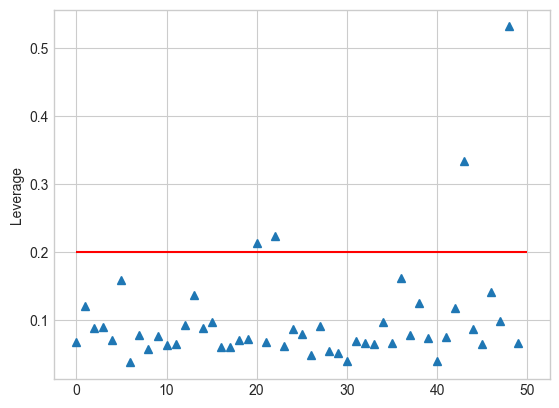

In [37]:
plt.plot(sav_inf.hat_matrix_diag,'^')
plt.hlines(y = 2*5 / 50,xmin = 0,xmax = 50,colors = 'red')
plt.ylabel('Leverage')

Text(1.9, 0.33, 'USA')

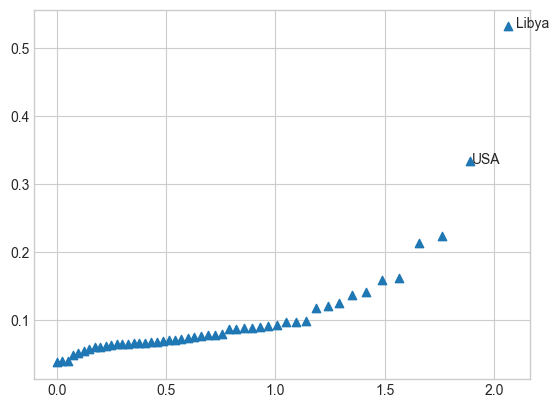

In [38]:
# Half normal plot
n = df_sav.shape[0]
ix = np.arange(1,n+1)
halfq = sp.stats.norm.ppf((n+ix) / (2*(n+1)))
plt.scatter(halfq,np.sort(sav_inf.hat_matrix_diag),marker = '^')
plt.annotate("Libya",(2.1,0.53))
plt.annotate("USA",(1.9,0.33))

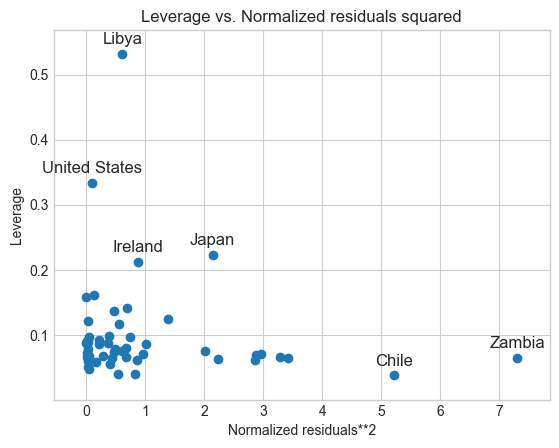

In [39]:
sm.graphics.plot_leverage_resid2(full_model);

***
## Bonferroni Correction
***

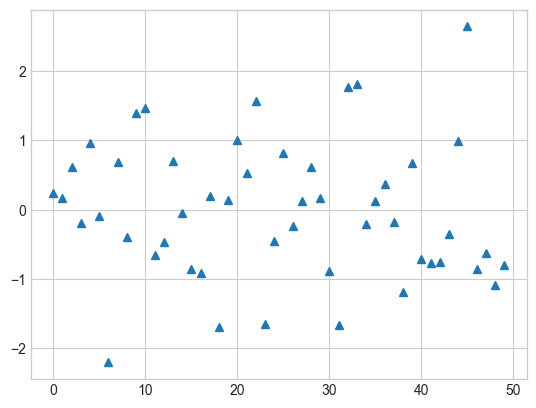

In [40]:
# Internal residual
plt.plot(sav_inf.resid_studentized_internal,'^')

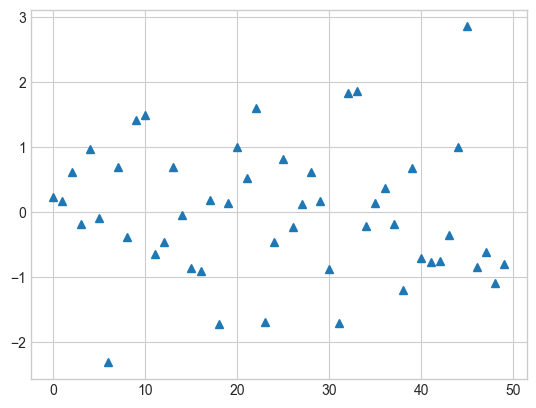

In [41]:
# External residual
plt.plot(sav_inf.resid_studentized_external,'^')

In [42]:
# No outlier indicate
p = full_model.df_model
jack_resid = pd.Series(sav_inf.resid_studentized_external,df_sav.index)
crit_v = abs(sp.stats.t.ppf(0.05 / (2*n),n - p - 1))
display(n,
        p,
        f'Largeist residual = {np.abs(jack_resid).max():.3f} < {crit_v:.3f}')

50

4.0

'Largeist residual = 2.854 < 3.520'

***
## Influence Plot
***

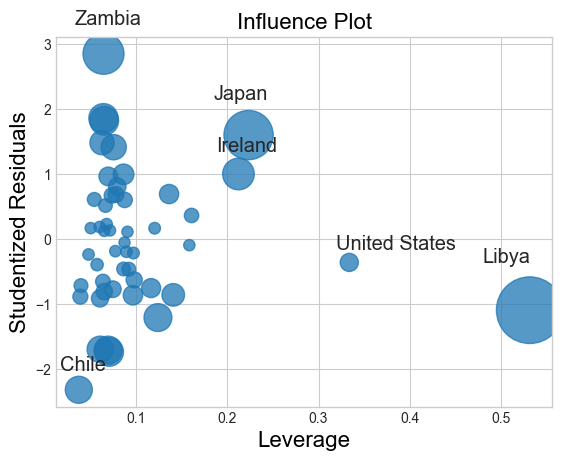

In [43]:
sm.graphics.influence_plot(full_model);

***
## Cook Distance
***

Text(0, 0.5, 'Cooks distance')

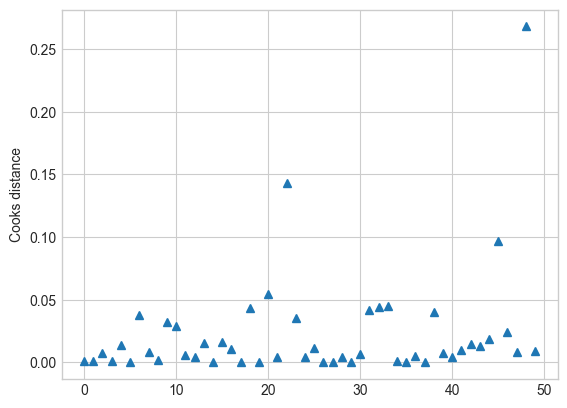

In [44]:
cook_dist = pd.Series(sav_inf.cooks_distance[0],df_sav.index)
cook_dist.sort_values(ascending = False).iloc[:5]
plt.plot(cook_dist.values,'^')
plt.ylabel('Cooks distance')

***
## Variance Stabilizing transform
***

In [45]:
df_gal = galapagos.load()
df_gal.head()

,Species,Area,Elevation,Nearest,Scruz,Adjacent
Baltra,58,25.09,346,0.6,0.6,1.84
Bartolome,31,1.24,109,0.6,26.3,572.33
Caldwell,3,0.21,114,2.8,58.7,0.78
Champion,25,0.10,46,1.9,47.4,0.18
Coamano,2,0.05,77,1.9,1.9,903.82


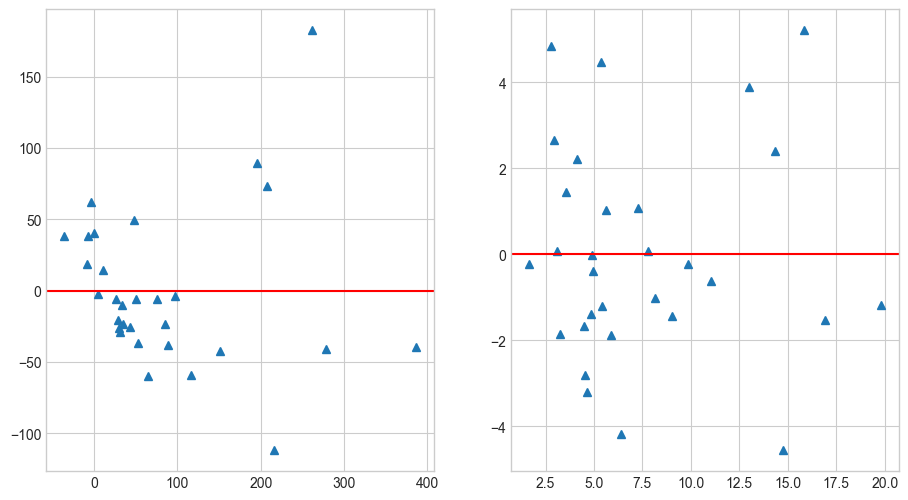

In [46]:
Xm = sm.add_constant(df_gal.loc[:,'Area':])
y = df_gal['Species']
ys = np.sqrt(y)
model_gal = sm.OLS(y,Xm).fit()
model_sqrt = sm.OLS(ys,Xm).fit()
plt.figure(figsize = [11,6])
plt.subplot(1,2,1)
plt.plot(model_gal.fittedvalues,model_gal.resid,'^')
plt.axhline(0,color = 'red')
plt.subplot(1,2,2)
plt.plot(model_sqrt.fittedvalues,model_sqrt.resid,'^')
plt.axhline(0,color = 'red')

***
## Box-Cox transform
***

C:\Users\User\AppData\Local\Temp\ipykernel_19836\2018325450.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'best')


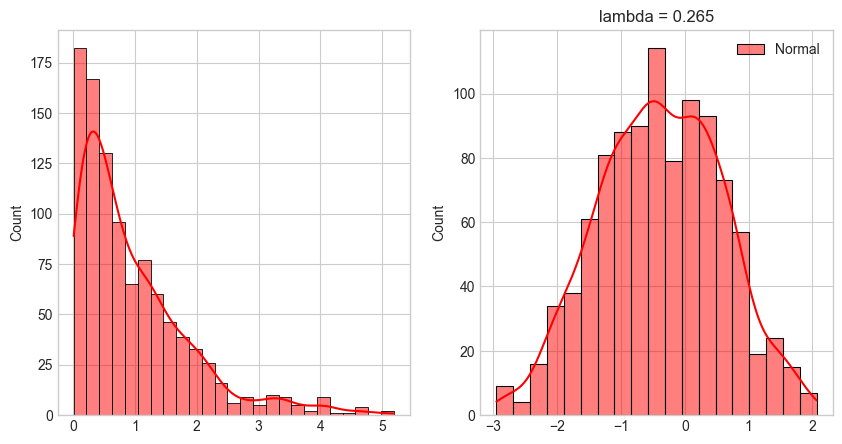

In [47]:
# original data
odf = np.random.exponential(size = 1000)
tdata, tlam = sp.stats.boxcox(odf)
fig, (ax1,ax2) = plt.subplots(1,2)
sns.histplot(odf,kde = True,label = 'Non-Normal',color = 'red',ax = ax1)
plt.legend(loc = 'best')
sns.histplot(tdata,kde = True,label = 'Normal',color = 'red',ax = ax2)
plt.title(f'lambda = {tlam:.3f}')
plt.legend(loc = 'best')
fig.set_figheight(5)
fig.set_figwidth(10)

***
## Normality check
***

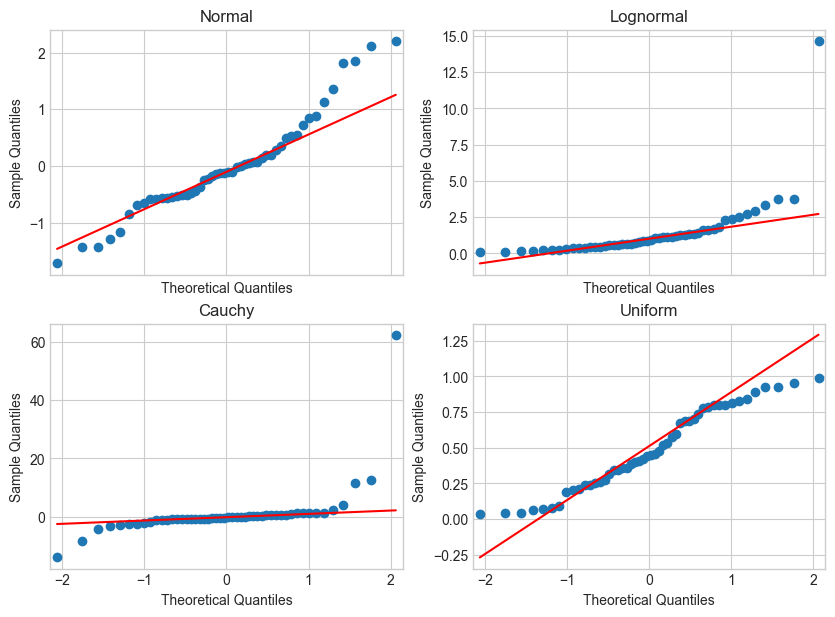

In [48]:
fig,ax = plt.subplots(2,2,sharex = True)
sm.qqplot(np.random.randn(50),line = 'q',ax = ax[0,0]);
sm.qqplot(np.exp(np.random.randn(50)),line = 'q',ax = ax[0,1]);
sm.qqplot(np.random.standard_t(1,50),line = 'q',ax = ax[1,0]);
sm.qqplot(np.random.sample(50),line = 'q',ax = ax[1,1]);
ax[0,0].set_title("Normal")
ax[0,1].set_title("Lognormal")
ax[1,0].set_title("Cauchy")
ax[1,1].set_title("Uniform")
fig.set_figheight(7)
fig.set_figwidth(10)

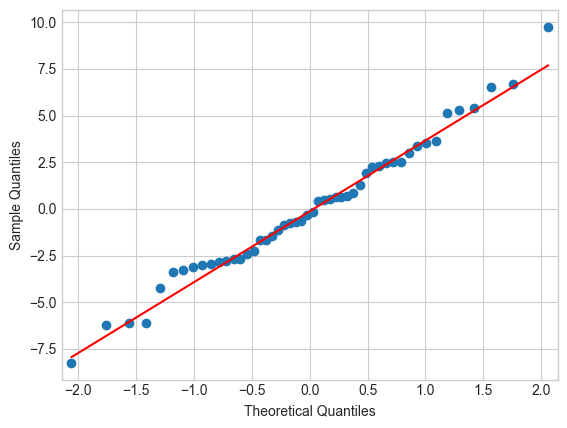

In [49]:
# Q-Q plot
sm.qqplot(full_model.resid,line = 'q');

Text(0.5, 0, 'Residual')

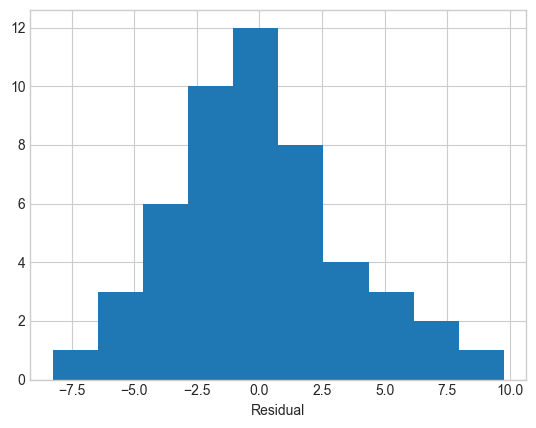

In [50]:
plt.hist(full_model.resid)
plt.xlabel('Residual')

In [51]:
norm_tbs = []
# Shapiro - Wilk test
# H0 : sample comes from a normal
val,pval = sp.stats.shapiro(full_model.resid)
norm_tbs.append(['Shapiro - Wilk test',val.item(),pval.item()])
# D'Agostino's K-squared test 
# H0 : data follows normal
val,pval = sp.stats.normaltest(full_model.resid)
norm_tbs.append(['D"Agostino"s K-squared test',val.item(),pval.item()])
# Kolmogorov–Smirnov test 
# H0 : the data belongs to the specific dist
val,pval = sp.stats.kstest(full_model.resid,'norm')
norm_tbs.append(['Kolmogorov–Smirnov test',val.item(),pval.item()])
# Jarque-Bera test
# H0 : Samples from a normal distribution 
#      have an expected skewness of 0 and 
#      an expected excess kurtosis of 0
val,pval = sp.stats.jarque_bera(full_model.resid)
norm_tbs.append(['Jarque-Bera test',val.item(),pval.item()])
pd.DataFrame(norm_tbs,columns = ['Method','Test Statistic','p-value']).set_index("Method")

,Test Statistic,p-value
Method,,
Shapiro - Wilk test,0.986984,0.852396
"D""Agostino""s K-squared test",0.866177,0.648503
Kolmogorov–Smirnov test,0.312620,0.000077
Jarque-Bera test,0.492933,0.781558


In [52]:
# Anderson–Darling test
# H0 : the data are normally distributed
val,pval,sval = sp.stats.anderson(full_model.resid,dist = 'norm')
display(f'Test Statistic = {val:.3f}',
        f'Critical value = {pval}',
        f'with significant = {sval}')

'Test Statistic = 0.266'

'Critical value = [0.538 0.613 0.736 0.858 1.021]'

'with significant = [15.  10.   5.   2.5  1. ]'

***
## Collinearity
***


In [53]:
df_seat = seatpos.load()
df_seat.head()

,Age,Weight,HtShoes,Ht,Seated,Arm,Thigh,Leg,hipcenter
0,46,180,187.2,184.9,95.2,36.1,45.3,41.3,-206.300
1,31,175,167.5,165.5,83.8,32.9,36.5,35.9,-178.210
2,23,100,153.6,152.2,82.9,26.0,36.6,31.0,-71.673
3,19,185,190.3,187.4,97.3,37.4,44.1,41.0,-257.720
4,23,159,178.0,174.1,93.9,29.5,40.1,36.9,-173.230


In [54]:
Xm = sm.add_constant(df_seat.iloc[:,:-1])
y = df_seat['hipcenter']
model_coll = sm.OLS(y,Xm).fit()
model_coll.summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hipcenter   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.600
No. Observations:                  38   F-statistic:                     7.940
Covariance Type:            nonrobust   Prob (F-statistic):           1.31e-05
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        436.4321    166.572      2.620      0.014      95.755     777.109
Age            0.7757      0.570      1.360      0.184      -0.391       1.942
Weight         0.0263      0.331      0.080      0.937      -0.651       0.703
HtShoes       -2.6924      9.753     -0.276      0.784     -22.640      17.255
Ht             0.6013     10.130      0.059      0.953     -20.117      21.319
Seated         0.5338      3.762      0.142      0.888      -7.160       8.228
Arm           -1.3281      3.900     -0.341      0.736      -9.305       6.649
Thigh         -1.1431      2.660     -0.430      0.671      -6.583       4.297
Leg           -6.4390      4.714     -1.366      0.182     -16.080       3.202
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

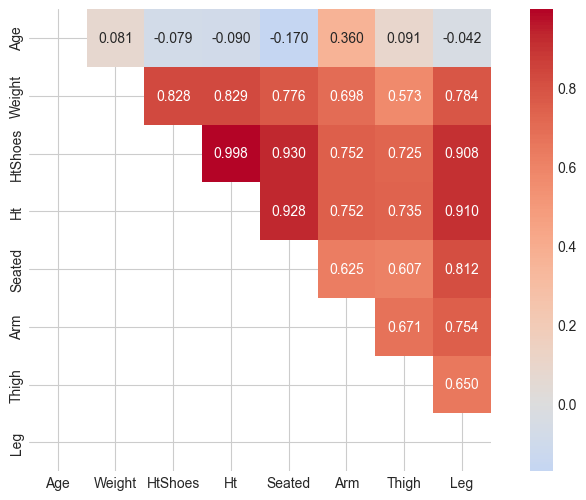

In [55]:
corM = Xm.iloc[:,1:].corr()
# Create a mask
mask = np.tril(corM)

plt.figure(figsize=(10, 6))
sns.heatmap(corM,mask = mask,center = 0,annot = True,
            fmt = '.3f',square = True,cmap = 'coolwarm')

In [56]:
Xf = model_coll.model.wexog
evals,evecs =np.linalg.eig(Xf.T @ Xf)
oevals = np.sort(evals)[::-1]
oevals

array([3653708.98133722,   21479.79190345,    9043.22608773,
           298.96405783,     148.40052819,      81.17463714,
            53.36194842,       7.29822578,       0.05127424])

In [57]:
oevals[0] / oevals[1:]

array([     170.0998314 ,      404.02716308,    12221.23156848,
          24620.59283669,    45010.47506914,    68470.30682953,
         500629.75490405, 71258176.42179964])

In [58]:
pd.Series([vif(Xf,k).item() for k in range(Xf.shape[1])],Xm.columns).sort_values(ascending = False)

const      741.029693
Ht         333.137832
HtShoes    307.429378
Seated       8.951054
Leg          6.694291
Arm          4.496368
Weight       3.647030
Thigh        2.762886
Age          1.997931
dtype: float64

***
## PCA
***

In [59]:
pca = PCA()
Xp = df_seat.iloc[:,:-1]
pca.fit(Xp)

PCA()

In [60]:
np.cumsum(pca.explained_variance_ratio_)

array([0.81924703, 0.95338137, 0.99228641, 0.99599742, 0.9979233 ,
       0.99910322, 0.99989213, 1.        ])

<BarContainer object of 8 artists>

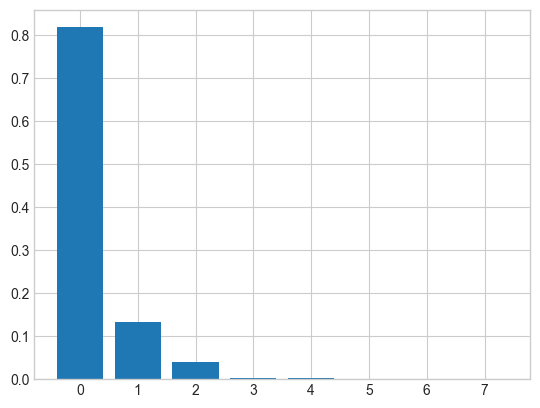

In [61]:
# prop each PCs contributes to the total variation
plt.bar(range(Xp.shape[1]),pca.explained_variance_ratio_)

In [62]:
pcScore = pca.fit_transform(Xp)
Zp = sm.add_constant(pcScore[:,:3])
model_pc = sm.OLS(y,Zp).fit()
model_pc.summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              hipcenter   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.630
No. Observations:                  38   F-statistic:                     21.99
Covariance Type:            nonrobust   Prob (F-statistic):           4.27e-08
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -164.8849      5.887    -28.010      0.000    -176.848    -152.922
x1            -1.0495      0.154     -6.808      0.000      -1.363      -0.736
x2             1.0995      0.381      2.886      0.007       0.325       1.874
x3            -2.3777      0.707     -3.361      0.002      -3.815      -0.940
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***
## Serial correlation
***

In [63]:
df_glob = globwarm.load()
df_glob.head()

,nhtemp,wusa,jasper,westgreen,chesapeake,tornetrask,urals,mongolia,tasman,year
0,NaN,-0.66,-0.03,0.03,-0.66,0.33,-1.49,0.83,-0.12,1000
1,NaN,-0.63,-0.07,0.09,-0.67,0.21,-1.44,0.96,-0.17,1001
2,NaN,-0.60,-0.11,0.18,-0.67,0.13,-1.39,0.99,-0.22,1002
3,NaN,-0.55,-0.14,0.30,-0.68,0.08,-1.34,0.95,-0.26,1003
4,NaN,-0.51,-0.15,0.41,-0.68,0.06,-1.30,0.87,-0.31,1004


In [64]:
df_glob_dr = df_glob.dropna()
df_glob_dr.head()

,nhtemp,wusa,jasper,westgreen,chesapeake,tornetrask,urals,mongolia,tasman,year
856,-0.37,-0.78,-0.15,-0.06,0.80,0.41,-0.05,-1.27,0.10,1856
857,-0.35,-0.81,-0.15,-0.24,0.70,0.46,-0.06,-1.18,0.25,1857
858,-0.33,-0.84,-0.15,-0.41,0.58,0.49,-0.08,-1.07,0.40,1858
859,-0.09,-0.85,-0.15,-0.57,0.44,0.49,-0.09,-0.98,0.52,1859
860,-0.37,-0.84,-0.16,-0.70,0.32,0.45,-0.11,-0.90,0.61,1860


In [65]:
Xm = sm.add_constant(df_glob_dr.iloc[:,1:-1])
y = df_glob_dr['nhtemp']
model_gal = sm.OLS(y,Xm).fit()

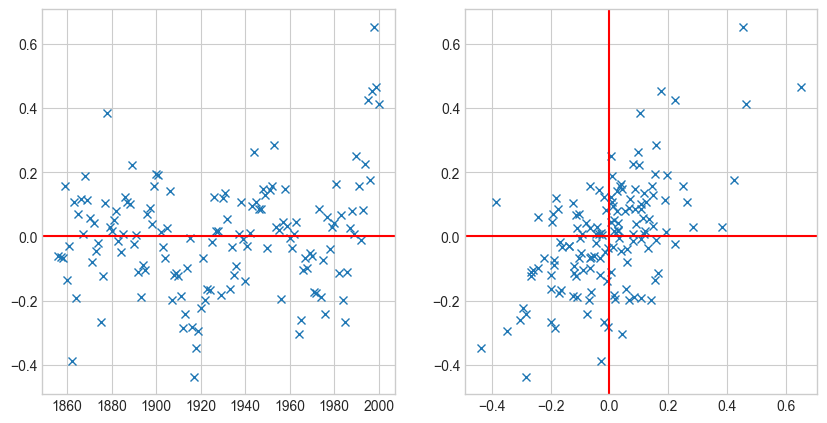

In [66]:
plt.figure(figsize = [10,5])
plt.subplot(1,2,1)
plt.plot(df_glob.year[model_gal.resid.keys()],model_gal.resid,'x')
plt.axhline(y = 0,color = 'red')
plt.subplot(1,2,2)
plt.plot(model_gal.resid[:-1],model_gal.resid[1:],'x')
plt.axhline(y = 0,color = 'red')
plt.axvline(x = 0,color = 'red')

In [67]:
sm.stats.stattools.durbin_watson(model_gal.resid)

np.float64(0.8166063726402725)

***
## Dummy (2 levels)
***

In [68]:
df_sex = sexab.load()
df_sex.head()

,cpa,ptsd,csa
1,2.04786,9.71365,Abused
2,0.83895,6.16933,Abused
3,-0.24139,15.15926,Abused
4,-1.11461,11.31277,Abused
5,2.01468,9.95384,Abused


In [69]:
cfun = ['min','median','max']
df_sex.groupby('csa').agg({'cpa':cfun,'ptsd':cfun})

cpa                       ptsd                    
               min   median      max      min    median       max
csa                                                              
Abused    -1.11461  2.62746  8.64690  5.98491  11.31277  18.99251
NotAbused -3.12036  1.32165  5.04974 -3.34921   5.79447  10.91447

<Axes: xlabel='cpa', ylabel='ptsd'>

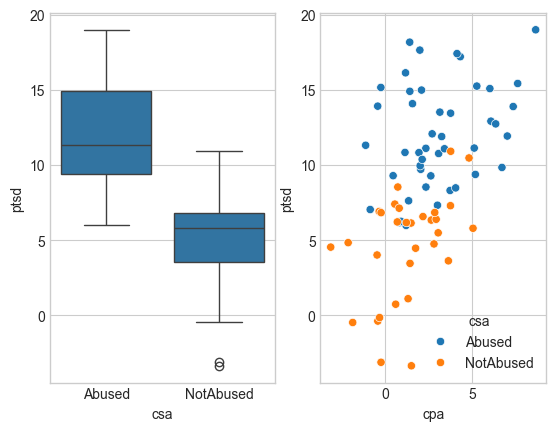

In [70]:
fig,ax = plt.subplots(1,2)
sns.boxplot(x = 'csa',y = 'ptsd',data = df_sex,ax = ax[0])
sns.scatterplot(x = 'cpa',y = 'ptsd',hue = 'csa',
                data = df_sex,ax = ax[1])

In [71]:
X = df_sex.csa.transform(lambda x:int(x == 'Abused'))
X = pd.concat([X,df_sex.csa.transform(lambda x:int(x == 'NotAbused'))],axis = 1)
X.columns = ['csa = Abused','csa = NotAbused']
Xm = sm.add_constant(X)
y = df_sex.ptsd
model_L2 = sm.OLS(y,Xm).fit()
model_L2.summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ptsd   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.513
No. Observations:                  76   F-statistic:                     79.90
Covariance Type:            nonrobust   Prob (F-statistic):           2.17e-13
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.5457      0.270     20.526      0.000       5.007       6.084
csa = Abused        6.3954      0.403     15.874      0.000       5.593       7.198
csa = NotAbused    -0.8498      0.450     -1.888      0.063      -1.747       0.047
===================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.43e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [72]:
Xm = Xm.drop('csa = Abused',axis = 1)
model_L21 = sm.OLS(y,Xm).fit()
model_L21.summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ptsd   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.513
No. Observations:                  76   F-statistic:                     79.90
Covariance Type:            nonrobust   Prob (F-statistic):           2.17e-13
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              11.9411      0.518     23.067      0.000      10.910      12.973
csa = NotAbused    -7.2452      0.811     -8.939      0.000      -8.860      -5.630
===================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
smf.ols('ptsd ~ csa',data = df_sex).fit().summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ptsd   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.513
No. Observations:                  76   F-statistic:                     79.90
Covariance Type:            nonrobust   Prob (F-statistic):           2.17e-13
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.9411      0.518     23.067      0.000      10.910      12.973
csa[T.NotAbused]    -7.2452      0.811     -8.939      0.000      -8.860      -5.630
====================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
model_L21.model.wexog[[0,44,45,75],:]

array([[1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.]])

In [75]:
# Reference level
smf.ols('ptsd ~ C(csa,Treatment(reference = "NotAbused"))',data = df_sex).fit().summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ptsd   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.513
No. Observations:                  76   F-statistic:                     79.90
Covariance Type:            nonrobust   Prob (F-statistic):           2.17e-13
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              4.6959      0.624      7.529      0.000       3.453       5.939
C(csa, Treatment(reference="NotAbused"))[T.Abused]     7.2452      0.811      8.939      0.000       5.630       8.860
======================================================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

***
## Dummy (More than 2 levels)
***

In [76]:
df_ff = fruitfly.load()
spec_row = [1,25,50,75,100]
display(df_ff[~df_ff.duplicated(subset = ['activity'])])

,thorax,longevity,activity
1,0.68,37,many
25,0.64,40,isolated
50,0.64,46,one
75,0.68,21,low
100,0.64,16,high


<Axes: xlabel='thorax', ylabel='longevity'>

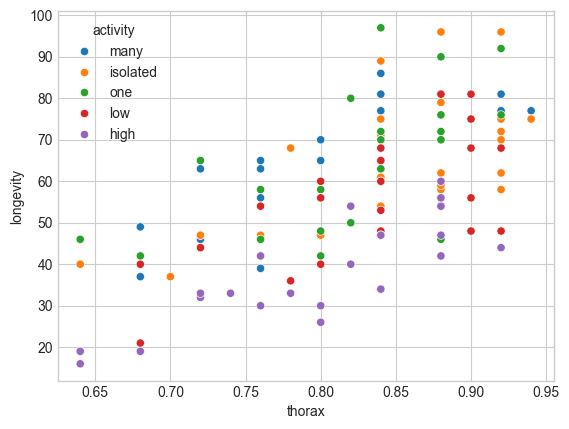

In [77]:
sns.scatterplot(x = 'thorax',y = 'longevity',hue = 'activity',data = df_ff)

In [78]:
model_ff = smf.ols('np.log(longevity) ~ C(activity,Treatment(reference = "isolated"))',data = df_ff).fit()
display(model_ff.summary(slim = True),
		model_ff.model.wexog[spec_row,:])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(longevity)   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.338
No. Observations:                 124   F-statistic:                     16.69
Covariance Type:            nonrobust   Prob (F-statistic):           6.96e-11
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                4.1193      0.056     72.986      0.000       4.008       4.231
C(activity, Treatment(reference="isolated"))[T.high]    -0.5172      0.080     -6.480      0.000      -0.675      -0.359
C(activity, Treatment(reference="isolated"))[T.low]     -0.1195      0.080     -1.497      0.137      -0.278       0.039
C(activity, Treatment(reference="isolated"))[T.many]     0.0240      0.081      0.297      0.767      -0.136       0.184
C(activity, Treatment(reference="isolated"))[T.one]      0.0234      0.080      0.294      0.770      -0.135       0.181
========================================================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[1., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0.]])

In [79]:
model_ffS = smf.ols('np.log(longevity) ~ C(activity,Sum)',data = df_ff).fit()
display(model_ffS.summary(slim = True),
        model_ffS.model.wexog[spec_row,:])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(longevity)   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.338
No. Observations:                 124   F-statistic:                     16.69
Covariance Type:            nonrobust   Prob (F-statistic):           6.96e-11
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.0015      0.025    157.875      0.000       3.951       4.052
C(activity, Sum)[S.high]        -0.3994      0.051     -7.903      0.000      -0.499      -0.299
C(activity, Sum)[S.isolated]     0.1179      0.051      2.332      0.021       0.018       0.218
C(activity, Sum)[S.low]         -0.0016      0.051     -0.033      0.974      -0.102       0.098
C(activity, Sum)[S.many]         0.1418      0.051      2.764      0.007       0.040       0.243
================================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[ 1.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  1.,  0.,  0.],
       [ 1., -1., -1., -1., -1.],
       [ 1.,  0.,  0.,  1.,  0.],
       [ 1.,  1.,  0.,  0.,  0.]])

***
## Piecewise Regression
***

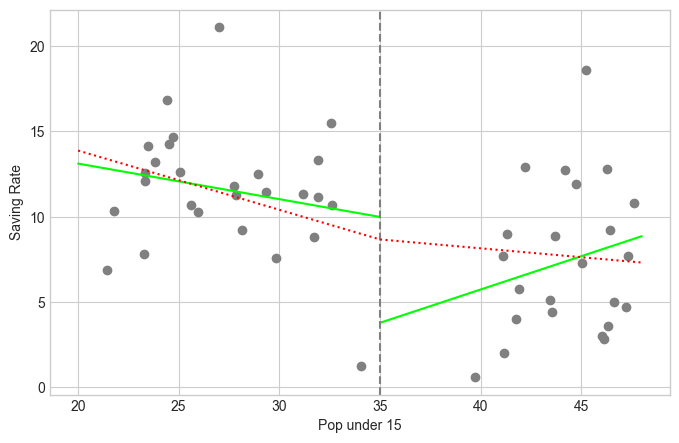

In [80]:
model_part1 = smf.ols('sr ~ pop15',data = df_sav[df_sav.pop15 < 35]).fit()
model_part2 = smf.ols('sr ~ pop15',data = df_sav[df_sav.pop15 > 35]).fit()
plt.figure(figsize = [8,5])
area_set = [(20,35),(35,48)]
model_set = [model_part1,model_part2]
for case,(a,b) in zip(model_set,area_set):
    y0 = np.sum(case.params.values * np.array([1,a]))
    y1 = np.sum(case.params.values * np.array([1,b]))
    plt.plot([a,b],[y0,y1],color = 'lime')
plt.scatter(df_sav.pop15,df_sav.sr,color = 'gray')
plt.xlabel('Pop under 15')
plt.ylabel('Saving Rate')
plt.axvline(35,color = 'gray',linestyle = 'dashed')
bL = lambda x,c:np.where(x < c,c - x,0)
bR = lambda x,c:np.where(x < c,0,x - c)
model_pr = smf.ols('sr ~ bL(pop15,35) + bR(pop15,35)',data = df_sav).fit()
xg = np.arange(20,49)
fpr = lambda x:np.sum(model_pr.params.values * np.array([1,bL(x,35),bR(x,35)]))
y_pr = list(map(fpr,xg))
plt.plot(xg,y_pr,linestyle = 'dotted',color = 'red')

***
## Polynomial Regression
***

In [81]:
df_eth = sm.datasets.get_rdataset("ethanol","lattice").data
df_eth.head()

,NOx,C,E
0,3.741,12.0,0.907
1,2.295,12.0,0.761
2,1.498,12.0,1.108
3,2.881,12.0,1.016
4,0.760,12.0,1.189


In [82]:
model_deg2 = smf.ols('NOx ~ E + np.power(E,2) + C',data = df_eth).fit()
model_deg2.summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    NOx   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.817
No. Observations:                  88   F-statistic:                     130.8
Covariance Type:            nonrobust   Prob (F-statistic):           1.47e-31
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -21.2030      1.240    -17.102      0.000     -23.669     -18.738
E                 52.4110      2.704     19.385      0.000      47.034      57.788
np.power(E, 2)   -29.0899      1.478    -19.679      0.000     -32.029     -26.150
C                  0.0635      0.014      4.635      0.000       0.036       0.091
==================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
model_deg4 = smf.ols('NOx ~ E + np.power(E,2) + np.power(E,3) + np.power(E,4) + C',data = df_eth).fit()
model_deg4.summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    NOx   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.928
No. Observations:                  88   F-statistic:                     224.1
Covariance Type:            nonrobust   Prob (F-statistic):           2.83e-46
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        161.7820     16.249      9.956      0.000     129.458     194.107
E               -821.3328     77.013    -10.665      0.000    -974.535    -668.130
np.power(E, 2)  1496.8577    133.971     11.173      0.000    1230.346    1763.369
np.power(E, 3) -1156.0814    101.392    -11.402      0.000   -1357.783    -954.380
np.power(E, 4)   321.1542     28.205     11.387      0.000     265.046     377.262
C                  0.0548      0.009      6.275      0.000       0.037       0.072
==================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [84]:
model_log = smf.ols('np.log(NOx) ~ E + np.power(E,2) + C',data = df_eth).fit()
model_log.summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(NOx)   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
No. Observations:                  88   F-statistic:                     292.6
Covariance Type:            nonrobust   Prob (F-statistic):           2.39e-44
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -13.9351      0.519    -26.875      0.000     -14.966     -12.904
E                 32.7990      1.131     29.007      0.000      30.550      35.048
np.power(E, 2)   -18.1650      0.618    -29.383      0.000     -19.394     -16.936
C                  0.0296      0.006      5.166      0.000       0.018       0.041
==================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

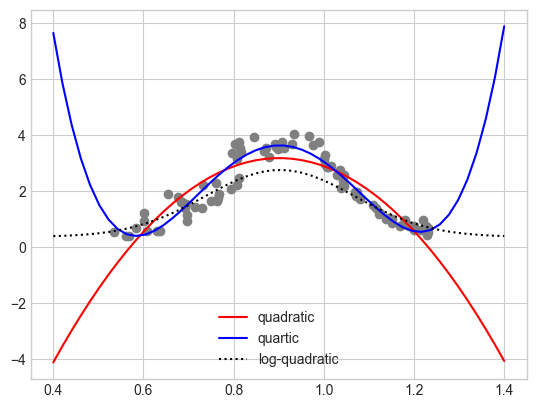

In [85]:
f4 = np.poly1d(model_deg4.params.iloc[[4,3,2,1,0]])
f2 = np.poly1d(model_deg2.params.iloc[[2,1,0]])
fL = np.poly1d(model_log.params.iloc[[2,1,0]])
plt.scatter(df_eth.E,df_eth.NOx,color = 'gray')
grids = np.linspace(0.4,1.4)
meanC = df_eth.C.mean()
plt.plot(grids,f2(grids) + meanC * model_deg2.params['C'],'r-',label = 'quadratic')
plt.plot(grids,f4(grids) + meanC * model_deg4.params['C'],'b-',label = 'quartic')
plt.plot(grids,np.exp(fL(grids)) + meanC * model_log.params['C'],'k:',label = 'log-quadratic')
plt.legend()

***
## Orthogonal Polynomial
***

In [86]:
# Legender Polynomial
E_scale = -1 + ((df_eth.E - df_eth.E.min()) * 2) / (df_eth.E.max() - df_eth.E.min())
X_Leg = np.hstack([np.polynomial.legendre.legvander(E_scale,4),df_eth.C.values.reshape(-1,1)])
model_Leg = sm.OLS(df_eth.NOx.values,X_Leg).fit()
display(model_Leg.summary(slim = True),
        np.corrcoef(X_Leg[:,1:5].T).round(3))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.928
No. Observations:                  88   F-statistic:                     224.1
Covariance Type:            nonrobust   Prob (F-statistic):           2.83e-46
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3299      0.111     12.032      0.000       1.110       1.550
x1             0.2711      0.059      4.586      0.000       0.154       0.389
x2            -2.4128      0.079    -30.393      0.000      -2.571      -2.255
x3            -0.3576      0.086     -4.153      0.000      -0.529      -0.186
x4             1.0828      0.095     11.387      0.000       0.894       1.272
x5             0.0548      0.009      6.275      0.000       0.037       0.072
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

array([[1.   , 0.303, 0.076, 0.17 ],
       [0.303, 1.   , 0.29 , 0.232],
       [0.076, 0.29 , 1.   , 0.35 ],
       [0.17 , 0.232, 0.35 , 1.   ]])

In [87]:
# generate orthogonal polynomial
b = sym.symbols('x')
d = 3
for n in range(d):
	moM = np.zeros((n,n+1))
	for i in range(n):
		for j in range(n+1):
			moM[i,j] = sp.integrate.quad(lambda x:x**(i+j),-1,1)[0]
	moMB = moM.tolist()
	moMB.append([b**k for k in range(n+1)])
	display(sym.Matrix(moMB),
		    sym.det(sym.Matrix(moMB)))


Matrix([[1]])

1

Matrix([
[2.0, 0.0],
[  1,   x]])

2.0*x

Matrix([
[2.0,               0.0, 0.666666666666667],
[0.0, 0.666666666666667,               0.0],
[  1,                 x,              x**2]])

1.33333333333333*x**2 - 0.444444444444444

***
## Model Selection
***

In [5]:
df_sd = statedata.load()
df_sd.set_index('State',inplace = True)
df_sd.head()

,Population,Income,Illiteracy,LifeExp,Murder,HSGrad,Frost,Area
State,,,,,,,,
AL,3615,3624,2.1,69.05,15.1,41.3,20,50708
AK,365,6315,1.5,69.31,11.3,66.7,152,566432
AZ,2212,4530,1.8,70.55,7.8,58.1,15,113417
AR,2110,3378,1.9,70.66,10.1,39.9,65,51945
CA,21198,5114,1.1,71.71,10.3,62.6,20,156361


In [6]:
y = df_sd.LifeExp
Xm = sm.add_constant(df_sd.drop('LifeExp',axis = 1))

In [90]:
# Best Subset Selection
best_optima = EFS(LinearRegression(),
                  max_features = Xm.shape[1],
                  scoring = 'r2',
                  print_progress = True).fit(Xm,y)
best_features = list(Xm.columns[list(best_optima.best_idx_)])
X_selected = sm.add_constant(Xm[best_features])
model_best = sm.OLS(y, X_selected).fit()
display(best_features,
        model_best.summary(slim = True))

Features: 255/255

['const', 'Population', 'Murder', 'HSGrad', 'Frost']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LifeExp   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.713
No. Observations:                  50   F-statistic:                     31.37
Covariance Type:            nonrobust   Prob (F-statistic):           1.70e-12
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.0271      0.953     74.542      0.000      69.108      72.946
Population  5.014e-05   2.51e-05      1.996      0.052   -4.54e-07       0.000
Murder        -0.3001      0.037     -8.199      0.000      -0.374      -0.226
HSGrad         0.0466      0.015      3.142      0.003       0.017       0.076
Frost         -0.0059      0.002     -2.455      0.018      -0.011      -0.001
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [91]:
# Backward selection
seq_optima = SFS(LinearRegression(),
                 forward = False,
                 scoring = 'r2',
                 k_features = 3).fit(Xm,y)
col_choice = list(Xm.columns[list(seq_optima.k_feature_idx_)])
Xc = sm.add_constant(Xm[col_choice])
model_bw = sm.OLS(y,Xc).fit()
display(model_bw.summary(slim = True))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                LifeExp   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.694
No. Observations:                  50   F-statistic:                     38.03
Covariance Type:            nonrobust   Prob (F-statistic):           1.63e-12
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.0364      0.983     72.246      0.000      69.057      73.016
Murder        -0.2831      0.037     -7.706      0.000      -0.357      -0.209
HSGrad         0.0499      0.015      3.286      0.002       0.019       0.081
Frost         -0.0069      0.002     -2.824      0.007      -0.012      -0.002
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

***
## Shrinkage
***

In [7]:
params = {'alpha':np.logspace(-10,-5,50)}
rr = GridSearchCV(Lasso(),params,scoring = 'r2',cv = 10)
rr.fit(Xm,y)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00000001, 0.00000001, 0.00000001,
       0.00000001, 0.00000001, 0.00000002, 0.00000002, 0.00000003,
       0.00000004, 0.00000004, 0.00000006, 0.00000007, 0.00000009,
       0.00000012, 0.00000015, 0.00000018, 0.00000023, 0.00000029,
       0.00000037, 0.00000047, 0.0000006 , 0.00000075, 0.00000095,
       0.00000121, 0.00000153, 0.00000193, 0.00000244, 0.00000309,
       0.00000391, 0.00000494, 0.00000625, 0.00000791, 0.00001   ])},
             scoring='r2')

In [8]:
opt_alpha = rr.best_params_['alpha']
opt_alpha

np.float64(1e-05)

In [12]:
model_lasso = Lasso(alpha = opt_alpha,fit_intercept = False).fit(Xm,y)
pd.DataFrame([model_lasso.feature_names_in_,model_lasso.coef_]).T

,0,1
0,const,71.377681
1,Population,0.000048
2,Income,-0.000019
3,Illiteracy,-0.098587
4,Murder,-0.296775
5,HSGrad,0.04472
6,Frost,-0.006621
7,Area,0.0
